In [1]:
import numpy as np
from matplotlib import pyplot as plt

from my_utils import *
from laplace2D import *


In [2]:
##################################################
##             define geometry, etc             ##
##################################################


x_step = 5e-6
y_step = x_step


my_grid = grid(-0.4e-3,0.4e-3,x_step,-0.3e-3,0.3e-3,y_step)


trace_width     = 100e-6
h               = 140e-6
trace_thickness = 100e-6

trace_x_pos    = 0e-6


trace = conductor(-trace_width/2 + trace_x_pos,
                  trace_width/2 + trace_x_pos,
                  h, h+trace_thickness, V=1)

plane = conductor(-trace_width/2 + trace_x_pos,
                  trace_width/2 + trace_x_pos,
                  -(h+trace_thickness),-h, V=-1)



conductor_list  = [trace,plane]
dielectric_list = []

In [3]:
##################################################
##            compute the potential             ##
##################################################

target_precision = .05e-3 # .05 mV potential difference

potential, epsilon = compute_potential(
                my_grid,
                conductor_list,
                dielectric_list,
                target_precision)

stepping level n=3
did 390 iterations - stopping
stepping level n=2
did 740 iterations - stopping
stepping level n=1
did 1300 iterations - stopping
stepping level n=0
did 2540 iterations - stopping
target precision of 5.000e-05 V reached on full sized grid ... stopping iteration


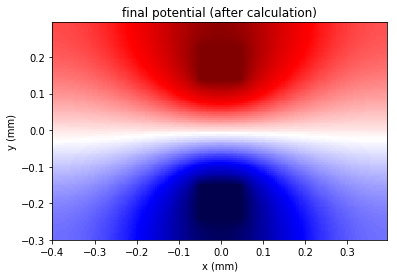

In [4]:
scale= np.max(abs(potential.matrix))
small_figure()

plt.pcolormesh(my_grid.X*1e3,my_grid.Y*1e3,potential.matrix,cmap="seismic")
plt.clim(-scale,scale)
plt.title("final potential (after calculation)")
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")
plt.show()

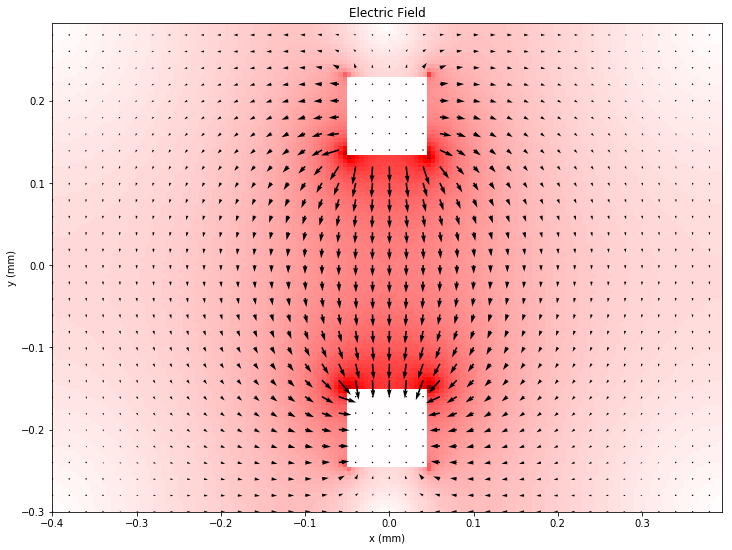

In [13]:
##################################################
##                 plot E field                 ##
##################################################

big_figure()

E = E_from_V(potential)

E_abs = E.abs_matrix()

scale = np.max(E_abs)

plt.pcolormesh(my_grid.X*1e3,my_grid.Y*1e3,E_abs, cmap='seismic')
plt.clim(-scale,scale)

coarse_E = coarsen_field(E,n=2)
plt.quiver(coarse_E.grid.X*1e3,coarse_E.grid.Y*1e3,coarse_E.matrix[:,:,0],coarse_E.matrix[:,:,1], scale=15*scale)

plt.title("Electric Field")
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")
plt.show()

In [6]:
rho = rho_from_V(potential,epsilon)

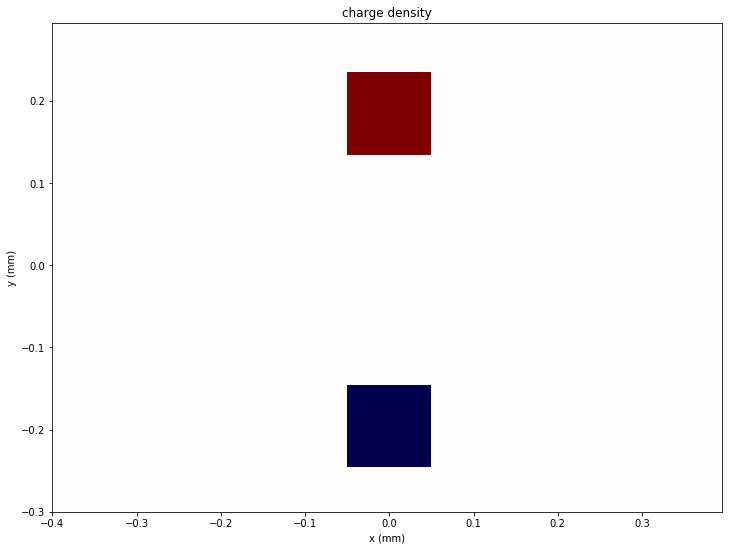

charge on trace: 23.428 pC
charge on plane: -24.986 pC


In [7]:
##################################################
##             current density                  ##
##################################################

conductor_mask, start_potential = conductors_to_mask(my_grid,conductor_list)

rhoj = start_potential

scale = np.max(np.abs(rhoj.matrix))

plt.pcolormesh(my_grid.X*1e3,my_grid.Y*1e3,rhoj.matrix,cmap="seismic")
plt.clim(-scale,scale)
plt.title("charge density")
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")
plt.show()


print("charge on trace: {:3.3f} pC".format(1e12* charge_on_conductor(rho,trace)))
print("charge on plane: {:3.3f} pC".format(1e12* charge_on_conductor(rho,plane)))

In [8]:
##################################################
##              calculate B field               ##
##################################################


Q = charge_on_conductor(rhoj,trace)

J = field(rhoj.grid)

J.matrix = rhoj.matrix/(Q/my_grid.area_element)

#B = B_of_conductors(J,conductor_list)
B = B_from_J(J)

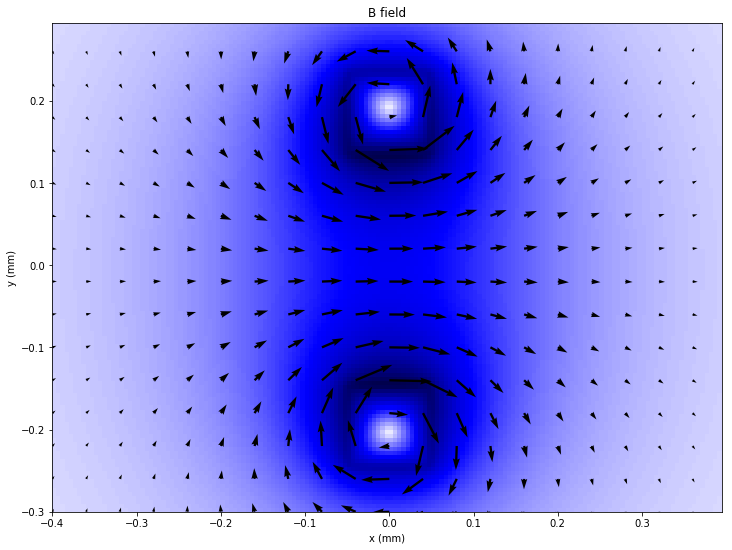

In [12]:
##################################################
##                 plot B field                 ##
##################################################


B_abs = B.abs_matrix()

scale = np.max(B_abs)

cmap="seismic"

#scale = 8e-3


plt.pcolormesh(my_grid.X*1e3,my_grid.Y*1e3, -B_abs, cmap=cmap)
plt.clim(-scale,scale)

coarse_B = coarsen_field(B,n=3)


plt.quiver(coarse_B.grid.X*1e3,coarse_B.grid.Y*1e3,coarse_B.matrix[:,:,0],coarse_B.matrix[:,:,1], scale=15*scale)

plt.title("B field")
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")
plt.show()


In [10]:
##################################################
##             calculate impedance              ##
##################################################


phi = flux_between_conductors(B,trace,plane)
I = 1
L = phi/I


Q = charge_on_conductor(rho,trace)
V = trace.V - plane.V
C = Q/V

Z = np.sqrt(abs(L/C))

print("C' = {:3.3f} pF/m".format(C*1e12))
print("L' = {:3.3f} uH/m".format(L*1e6))
print("Z  = {:3.3f} R".format(Z))

C' = 11.714 pF/m
L' = 0.960 uH/m
Z  = 286.247 R


In [11]:
##################################################
##                lecherleitung                 ##
##################################################

# abstand
a = h*2
# Durchmesser
d = trace_width

C = np.pi*eps_0*1/(np.arccosh(a/d))
L = 1/np.pi*mu_0*np.arccosh(a/d)
#Z = 120*np.arccosh(a/d)
Z = np.sqrt(L/C)


print("C' = {:3.3f} pF/m".format(C*1e12))
print("L' = {:3.3f} uH/m".format(L*1e6))
print("Z  = {:3.3f} R".format(Z))



C' = 16.467 pF/m
L' = 0.676 uH/m
Z  = 202.568 R
